In [1]:
%pylab inline
import glob

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Get data 
import pandas as pd
from PIL import Image

def get_names():
  names = pd.read_csv('signnames.csv')
  for i in names['ClassId']:
    yield i

folder = []
for i in glob.glob('data_train/*'):
  folder.append(i)
  
folder.sort()

images = []
labels = []
gen = get_names()
for i in folder:
  aux = next(gen)
  for j in glob.glob((i+'/*.ppm')):
    temp = Image.open(j)
    keep = temp.copy()
    images.append(keep)
    labels.append(aux)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import trange, tqdm

In [4]:
from PIL import Image

In [5]:
# Resize to (33, 33) and convert to tensor
tfms = transforms.Compose([transforms.Resize((33, 33)), transforms.ToTensor(),])

In [6]:
# Apply transforms
imgs = [tfms(i) for i in images]
imgs = torch.stack(imgs)

labels = torch.tensor(labels).long()

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(imgs, labels, random_state=42)

In [8]:
BS = 64
trainset = list(zip(X_train, Y_train))
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BS, 
                                          shuffle=False, num_workers=2)

In [9]:
class Net(torch.nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv1 = nn.Conv2d(3, 100, kernel_size=5)
    self.bn1 = nn.BatchNorm2d(100)
    self.conv2 = nn.Conv2d(100, 150, kernel_size=3)
    self.bn2 = nn.BatchNorm2d(150)
    self.conv3 = nn.Conv2d(150, 250, kernel_size=3)
    self.bn3 = nn.BatchNorm2d(250)
    self.conv_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(250 * 2 * 2, 350)
    self.fc2 = nn.Linear(350, 43)

  def forward(self, x):
    x = self.bn1(self.pool(F.relu(self.conv1(x))))
    x = self.conv_drop(x)
    x = self.bn2(self.pool(F.relu(self.conv2(x))))
    x = self.conv_drop(x)
    x = self.bn3(self.pool(F.relu(self.conv3(x))))
    x = self.conv_drop(x)
    x = torch.flatten(x, 1) # flatten all dimensions except batch
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

  0%|          | 0/460 [00:00<?, ?it/s]/home/henistein/.local/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
loss 0.08 accuracy 0.97: 100%|██████████| 460/460 [00:38<00:00, 11.89it/s]


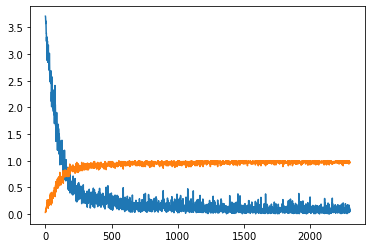

In [10]:
net = Net()

loss_function = nn.CrossEntropyLoss()
optim = torch.optim.Adam(net.parameters(), lr=0.001)

losses, accuracies = [], []

for _ in range(5):
  for i, data in enumerate(t:=tqdm(trainloader)):
    X, Y = data
    X = Variable(X)
    Y = Variable(Y)

    optim.zero_grad()

    # forward (contains activation function inside)
    out = net(X)

    # Loss function
    loss = loss_function(out, Y)

    # Bacward and optimizer
    loss.backward()
    optim.step()

    # Stats
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    accuracy = accuracy.item()
    loss = loss.item()
    accuracies.append(accuracy)
    losses.append(loss)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plot(losses)
plot(accuracies)

In [11]:
# Eval
net.eval()
Y_pred = net(X_test)

In [12]:
(torch.argmax(Y_pred, dim=1) == Y_test).numpy().mean()

0.9948995205549321